### Shap Classification

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None

In [2]:
# Both features and target have already been scaled: mean = 0; SD = 1
# See Chapter 4-0 for a descrition of this dataset
path = './data/'
df_train = pd.read_excel(path + 'lendingclub_traindata.xlsx') 
df_test = pd.read_excel(path + 'lendingclub_testdata.xlsx') 
df_train.head()

,home_ownership,income,dti,fico_low,loan_status
0,1,44.304,18.47,690,0
1,0,38.500,33.73,660,0
2,1,54.000,19.00,660,0
3,1,60.000,33.98,695,0
4,0,39.354,10.85,685,0


In [3]:
from sklearn.model_selection import train_test_split

cols = list(df_train.columns)
cols.remove('loan_status')
X_train = df_train[cols].copy()
y_train = df_train['loan_status'].copy()

X_test = df_test[cols].copy()
y_test = df_test['loan_status'].copy()

print("X_train & y_train shape:", X_train.shape, y_train.shape)
print("X_test & y_test shape:", X_test.shape, y_test.shape)

X_train & y_train shape: (8695, 4) (8695,)
X_test & y_test shape: (5916, 4) (5916,)


In [4]:
X_train.head()

,home_ownership,income,dti,fico_low
0,1,44.304,18.47,690
1,0,38.500,33.73,660
2,1,54.000,19.00,660
3,1,60.000,33.98,695
4,0,39.354,10.85,685


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

base_estimator = GradientBoostingClassifier()

params = { 
    "learning_rate" : [0.01, 0.1, 0.5, 0.05],
    'n_estimators': [5, 10, 20, 50],
   "max_depth":[2,3,5]}    

gd = GridSearchCV(
    base_estimator,  
    params, 
    cv = 5,  
    scoring = "roc_auc",
    n_jobs = 4,
    verbose = 5, 
    refit = True
)

gd.fit(X_train, y_train)
result = pd.DataFrame(gd.cv_results_)
best_params = result.sort_values("rank_test_score")["params"][0]
best_model = gd.best_estimator_
prob_a = best_model.predict_proba(X_test)[:,1]

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [6]:
best_params

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 5}

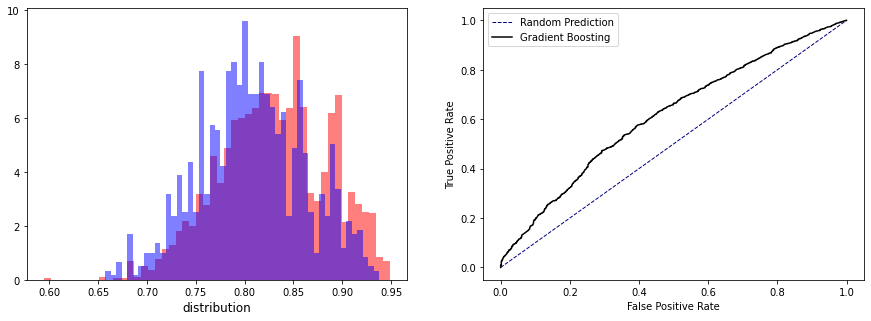

AUC Score :  0.6136343030536032


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
fig , ax = plt.subplots(1,2, figsize = (15,5))

uno_distr = prob_a[y_test==1]
zero_distr = prob_a[y_test==0]
ax[0].hist(uno_distr, color="red", label = "score(z|y=1)", density=True, alpha=0.5, bins=50)
ax[0].hist(zero_distr, color="blue", label = "score(z|y=0)", density=True, alpha=0.5, bins=50)
ax[0].set_xlabel("score", fontsize=12)
ax[0].set_xlabel("distribution", fontsize=12)

lr_auc=roc_auc_score(y_test, prob_a)
lr_fpr_gradient,lr_tpr_gradient, thresholds =roc_curve(y_test,prob_a)

ax[1].plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
ax[1].plot(lr_fpr_gradient,lr_tpr_gradient , color="black" , label='Gradient Boosting')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()
plt.legend()
plt.show()
print("AUC Score : ", lr_auc)

<AxesSubplot:>

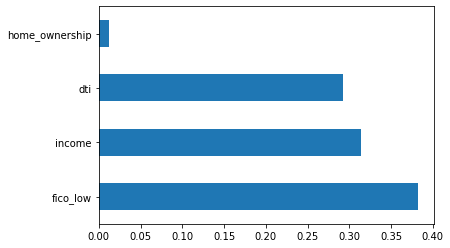

In [8]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

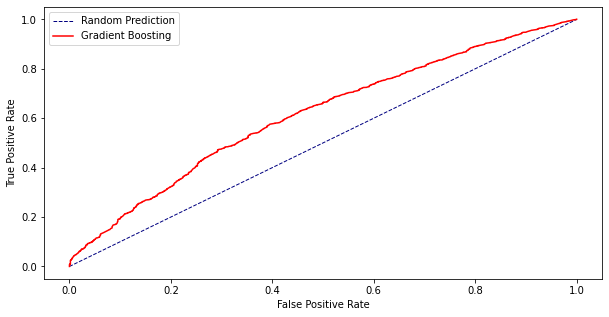

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
ax.plot(lr_fpr_gradient,lr_tpr_gradient , color="red" , label='Gradient Boosting')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
plt.legend()
plt.show()

In [94]:
import shap

explainer = shap.TreeExplainer(best_model, model_output="raw", features_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)

In [95]:
shap_values.shape

(5916, 4)

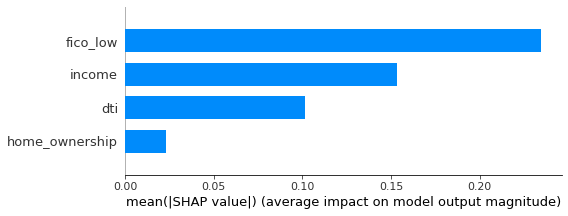

In [96]:
shap.summary_plot(shap_values,X_test , plot_type="bar")

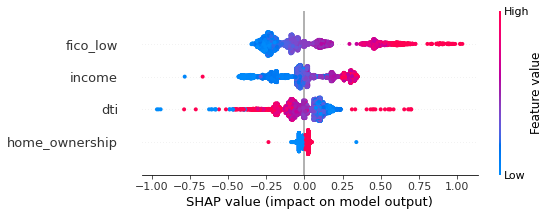

In [97]:
shap.summary_plot(shap_values, X_test)

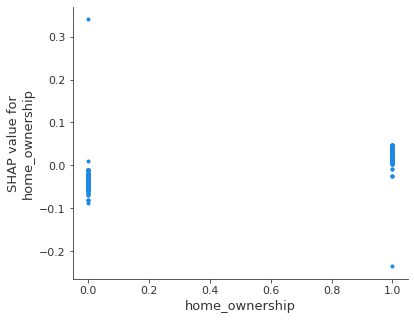

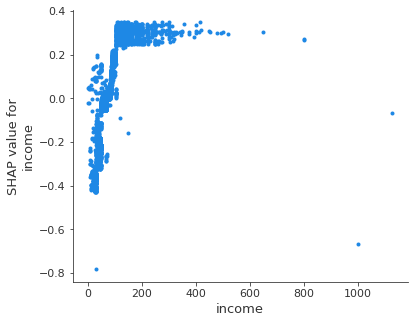

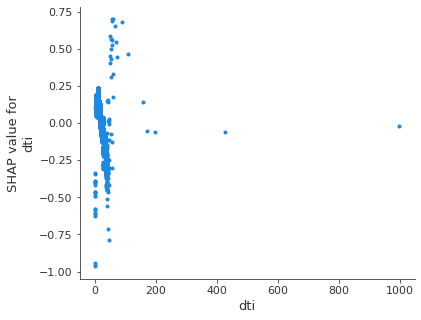

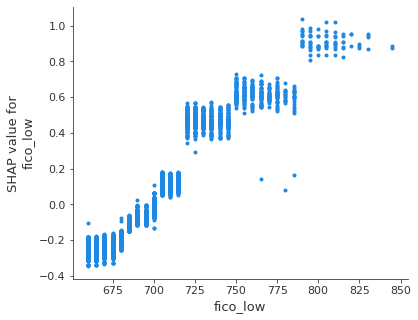

In [98]:
for name in X_test.columns:
    shap.dependence_plot(name, shap_values, X_test, interaction_index=None)#, display_features=X_display)

In [111]:
i = 18
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i], X_test.loc[i]) #link="logit" to see probability

In [100]:
shap_values.sum(axis=1)

array([ 0.15817852,  0.49802901, -0.78309542, ..., -0.49605074,
       -0.24710833, -0.56786677])

In [101]:
appo = explainer.expected_value + shap_values.sum(axis=1)
shap_sum_logit = np.exp(appo)/(1+np.exp(appo))

In [102]:
shap_sum_logit

array([0.85580213, 0.8928992 , 0.6983765 , ..., 0.75521524, 0.79827792,
       0.741697  ])

In [103]:
prob_a

array([0.85580213, 0.8928992 , 0.6983765 , ..., 0.75521524, 0.79827792,
       0.741697  ])

In [104]:
#shap_values.sum(axis=1) + y_train.mean()

In [105]:
#y_test.mean(), y_train.mean()

In [107]:
explainer.expected_value  #, np.log(y_test.mean()/(1-y_test.mean())), np.log(y_train.mean()/(1-y_train.mean()))

array([1.62267424])

In [109]:
prob_a_test = best_model.predict_proba(X_test)[:,1]
np.log(prob_a_test/(1-prob_a_test)).mean()

1.6117853311650057

In [110]:
prob_a_train = best_model.predict_proba(X_train)[:,1]
np.log(prob_a_train/(1-prob_a_train)).mean()

1.6226742440964674